In [1]:
from dotenv import load_dotenv

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from groq import Groq
import operator
from langchain_groq import ChatGroq
import json
from langchain_openai import ChatOpenAI

from IPython.display import display, Image

In [3]:
load_dotenv()

True

In [4]:
tool = TavilySearchResults(max_results=4)

C:\Users\badho\AppData\Local\Temp\ipykernel_7140\3520374918.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4)


In [5]:
tool("Who is the cureent president of the United States?")

C:\Users\badho\AppData\Local\Temp\ipykernel_7140\4091618216.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  tool("Who is the cureent president of the United States?")


[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\nPresident of the United States\n\nThe president of the United States is the:\n\n   U.S. head of state\n   Leader of the executive branch\n   Commander in chief of the armed forces\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump.He was sworn into office on January 20, 2025. [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and cur

In [6]:
tool.name

'tavily_search_results_json'

In [7]:
class AgentState(TypedDict):
    messages:Annotated[list[AnyMessage], operator.add]

In [8]:
class Agent:

    def __init__(self, state:AgentState, tools, system_msg="", model_name="llama-3.1-8b-instant"):
        self.system_msg = system_msg
        self.graph = StateGraph(state)
        self.model = ChatGroq(model=model_name)
        self.model_name = model_name
        self.graph.add_node("llm", self.call_llm)
        self.graph.add_node("action", self.action)
        self.graph.set_entry_point("llm")
        self.graph.add_edge("action", "llm")
        self.graph.add_conditional_edges(
            "llm",
            self.continue_action,
            {True:"action", False: END}
        )
        self.graph = self.graph.compile()
        
        self.tools = {t.name: t for t in tools}
        #self.model = self.model.bind_tools(self.tools)
        self.model = self.model.bind_tools(list(self.tools.values()))

    def call_llm(self, state:AgentState)->AgentState:
        messages = state['messages']
        if self.system_msg:
            messages = [SystemMessage(content= self.system_msg)] + messages 
        res = self.model.invoke(messages)
        return {'messages':[res]}
    def continue_action(self, state:AgentState):

        last_res = state['messages'][-1]
        return len (last_res.tool_calls) > 0
    def action(self,state:AgentState)->AgentState:
        last_res = state['messages'][-1]
        tool_result = []
        print(last_res.tool_calls)

        for tool_call in last_res.tool_calls:
            print(f"Calling tool {tool_call['name']} with args {tool_call['args']}")
            if tool_call['name'] in self.tools:
                res = self.tools[tool_call['name']].invoke(tool_call['args']['query'])
                #content=json.dumps(res, ensure_ascii=False)  # or str(res)
                print(f"Tool result: {str(res)}")
                tool_result.append(ToolMessage(content=str(res), name=tool_call['name'], tool_call_id = tool_call['id']))
            else:
                print("Tool not foun")
                tool_result.append(ToolMessage(content=f"Tool {tool_call.name} not found", tool_call=tool_call))
        return {'messages': tool_result}


In [9]:
tool.name

'tavily_search_results_json'

In [10]:
tools = [tool]


In [11]:
tools[0].name

'tavily_search_results_json'

In [12]:
agent = Agent(AgentState, tools, system_msg="You are a helpful AI assistant.", model_name="llama-3.1-8b-instant")

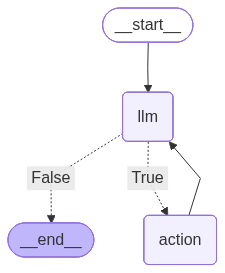

In [13]:
display(Image(agent.graph.get_graph().draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="What is the current weather in sf?")]


In [15]:
result = agent.graph.invoke({'messages': messages})

[{'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in San Francisco'}, 'id': 'j9x0dsfyq', 'type': 'tool_call'}]
Calling tool tavily_search_results_json with args {'query': 'Current weather in San Francisco'}
Tool result: [{'title': 'San Francisco, CA Weather Conditions', 'url': 'https://www.wunderground.com/weather/us/ca/san-francisco', 'content': "# San Francisco, CA Weather Conditionsstar\\_ratehome\n\nicon\n\nThank you for reporting this station. We will review the data in question.\n\nYou are about to report this weather station for bad data. Please select the information that is incorrect.\n\nSee more\n\n(Reset Map)\n\nNo PWS\n\nReset Map, or Add PWS.\n\naccess\\_time 2:16 PM PST on November 8, 2025 (GMT -8) | Updated 9 seconds ago\n\nicon\n\nFair\n\nGusts 2 °mph\n\nToday's temperature is forecast to be WARMER than yesterday. [...] icon\nicon\nicon\nicon\nicon\nicon\nicon\nicon\nAccess Logo\n\nWe recognize our responsibility to use data and technology for g

In [ ]:
result['messages']

[HumanMessage(content='What is the current weather in sf?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'j9x0dsfyq', 'function': {'arguments': '{"query":"Current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 293, 'total_tokens': 315, 'completion_time': 0.03029511, 'prompt_time': 0.016056108, 'queue_time': 0.086939921, 'total_time': 0.046351218}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--329566f5-fbcd-434c-8bdd-0eb7f000ddf6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Current weather in San Francisco'}, 'id': 'j9x0dsfyq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 22, 'total_tokens': 315}),
 ToolMessage(content='[{\'titl

In [18]:
result['messages'][-1].content

'Based on the search results, the current weather in San Francisco is partly sunny with a high temperature of 73°F (23°C) and a low temperature of 54°F (12°C). There is a chance of showers and rain later in the day. It is recommended to check the weather forecast for the most up-to-date information.'

In [19]:
messages = [HumanMessage(content="What about in berlin?")]
result = agent.graph.invoke({'messages': messages})

[{'name': 'tavily_search_results_json', 'args': {'query': 'Berlin current events'}, 'id': 'rwbndyk4q', 'type': 'tool_call'}]
Calling tool tavily_search_results_json with args {'query': 'Berlin current events'}
Tool result: [{'title': 'News from Berlin - Berlin.de', 'url': 'https://www.berlin.de/en/news/', 'content': 'The latest news, up-to-date information and developments from Berlin. The news are brought to you by the Deutsche Presse-Agentur (dpa) and the BerlinOnline GmbH.\n\n## Latest news\n\n#### Friday, 7 November 2025\n\nBürgermeister Kai Wegner\n\n© dpa\n\n### “Suffering and Freedom” – Wegner commemorates November 9\n\nKai Wegner talks about guilt, hope, responsibility, and reconciliation: What November 9 means for Berlin and our society. \n more\n\n36 years since the fall of the Berlin Wall on November 9, 1989 [...] The new construction of the bridge over Blumberger Damm in Berlin-Marzahn is complete. It was officially opened to traffic at a ceremony on Tuesday morning. \n mor

In [20]:
result['messages']

[HumanMessage(content='What about in berlin?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rwbndyk4q', 'function': {'arguments': '{"query":"Berlin current events"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 290, 'total_tokens': 310, 'completion_time': 0.038851871, 'prompt_time': 0.016525735, 'queue_time': 0.090364223, 'total_time': 0.055377606}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8afe7725-d39d-4485-9879-0c501a785c6a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Berlin current events'}, 'id': 'rwbndyk4q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 290, 'output_tokens': 20, 'total_tokens': 310}),
 ToolMessage(content='[{\'title\': \'News from Berlin - Berlin.d

In [21]:
result['messages'][-1].content

"Based on the search results, it appears that there are several current events happening in Berlin. Some of the top news stories include:\n\n* The 36th anniversary of the fall of the Berlin Wall on November 9, 1989\n* The opening of a new bridge over Blumberger Damm in Berlin-Marzahn\n* The first cases of bird flu reported in Berlin\n* The doubling of the number of trees in the city by 2040\n* The opening of ice rinks in Neukölln and Lankwitz\n* The collection of clothing for homeless people\n\nIt's worth noting that some of these stories may be more relevant than others depending on your specific interests and needs. If you're looking for more information on a particular topic, I'd be happy to help you further."

Problem: The state only preserve a single graph execution, so we need something to store all the conversations in a session or in a chat. LangGraph has multiple options for that, one easiest could be checkpointer(persistence).